# Imports

In [ ]:
import math
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold  # stratified splits for class balance
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import xgboost as xgb


## Set random seeds for reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else
                     'mps' if torch.backends.mps.is_available() else
                     'cpu')

In [ ]:
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading & Prep

In [ ]:
def load_data(train_path: str, val_path: str):
    """Load training and validation data from pickle files."""
    try:
        with open(train_path, "rb") as f:
            train_data = pickle.load(f)
        with open(val_path, "rb") as f:
            val_data = pickle.load(f)
    except Exception as e:
        print(f"Error loading data: {e}")
        raise e
    return train_data, val_data

In [ ]:
def print_sample_data(train_data):
    """Print first sample and first feature of the 10th sample for sanity check."""
    print("First sample:")
    print(train_data[0])
    print("\nFirst feature of 10th sample:")
    print(train_data[9][0])

In [ ]:
def combine_data(train_data, val_data):
    """
    Combine training and validation data.
    Assumes first column is label, rest are features.
    """
    X_train, y_train = train_data[:, 1:], train_data[:, 0]
    X_val, y_val = val_data[:, 1:], val_data[:, 0]
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])
    print(f"\nCombined dataset shape: {X_combined.shape}")
    unique, counts = np.unique(y_combined, return_counts=True)
    print("\nClass distribution in combined dataset:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples")
    return X_combined, y_combined

In [ ]:
def extract_features(X: np.ndarray) -> np.ndarray:
    """
    Extract a set of handcrafted features from each sample.
    Returns a feature array with each row representing a sample's features.
    """
    features = []
    for sample in X:
        # Statistical features
        mean = np.mean(sample)
        std = np.std(sample)
        skew = stats.skew(sample)
        kurt = stats.kurtosis(sample)
        # Peak features
        peaks = np.diff(np.sign(np.diff(sample)))
        n_peaks = np.sum(peaks != 0)
        # Waveform features
        rms = np.sqrt(np.mean(sample**2))
        crest_factor = np.max(np.abs(sample)) / rms if rms != 0 else 0
        # ECG-specific features
        zero_crossings = np.sum(np.diff(np.signbit(sample)))
        peak_to_peak = np.max(sample) - np.min(sample)
        # Frequency domain features
        fft_features = np.abs(np.fft.fft(sample))[:10]
        # Additional statistical features
        q1 = np.percentile(sample, 25)
        q3 = np.percentile(sample, 75)
        iqr = q3 - q1
        # Slope features
        slopes = np.diff(sample)
        mean_slope = np.mean(slopes)
        max_slope = np.max(np.abs(slopes))
        feat = np.concatenate([
            [mean, std, skew, kurt, n_peaks, rms, crest_factor,
             zero_crossings, peak_to_peak, q1, q3, iqr, mean_slope, max_slope],
            fft_features
        ])
        features.append(feat)
    return np.array(features)


## 2. Data Augmentation  

In [ ]:
def augment_signal(signal, noise_std=0.005, shift_max=5):
    """
    Apply simple augmentation: random noise and random shifting.
    """
    # Add Gaussian noise
    noise = np.random.normal(0, noise_std, size=signal.shape)
    signal_noisy = signal + noise
    # Random shift (roll)
    shift = np.random.randint(-shift_max, shift_max)
    signal_shifted = np.roll(signal_noisy, shift)
    return signal_shifted

In [ ]:
class ECGDataset(Dataset):
    """Custom Dataset for ECG data with optional augmentation."""
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        # Optionally augment during training
        if self.augment:
            sample = augment_signal(sample)
        # Return tensor version
        return torch.FloatTensor(sample), torch.tensor(self.y[idx], dtype=torch.long)


## 3. Improved Model Architectures

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        # Shortcut layer in case of channel mismatch
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

In [ ]:
class CNN1D_Residual(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D_Residual, self).__init__()
        self.layer1 = ResidualBlock(1, 32)
        self.pool1 = nn.MaxPool1d(2)
        self.layer2 = ResidualBlock(32, 64)
        self.pool2 = nn.MaxPool1d(2)
        self.layer3 = ResidualBlock(64, 64)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        # x: (batch_size, sequence_length)
        x = x.unsqueeze(1)  # -> (batch_size, 1, seq_length)
        x = self.pool1(self.layer1(x))
        x = self.pool2(self.layer2(x))
        x = self.layer3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Improved Transformer with learned positional embedding and attention pooling

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, d_model=64, nhead=8, num_layers=3, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.d_model = d_model

        # Learned positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, input_size, d_model))
        # Project input feature to d_model dimensions
        self.input_projection = nn.Linear(1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Attention pooling: learn a query vector to pool over sequence length
        self.attention_query = nn.Parameter(torch.randn(d_model))
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch_size, sequence_length)
        batch_size = x.size(0)
        x = x.unsqueeze(-1)  # -> (batch_size, sequence_length, 1)
        x = self.input_projection(x)  # -> (batch_size, sequence_length, d_model)
        x = x + self.pos_embedding  # add learned positional embedding
        x = self.transformer_encoder(x)  # -> (batch_size, sequence_length, d_model)
        # Attention pooling: compute attention weights with a learnable query
        attn_weights = torch.softmax(torch.matmul(x, self.attention_query), dim=1)  # (batch_size, seq_length)
        x = torch.sum(x * attn_weights.unsqueeze(-1), dim=1)  # weighted sum -> (batch_size, d_model)
        x = self.fc(x)
        return x

## 4. Training Utilities

In [ ]:
def save_model(model, model_name, fold, metrics):
    """Save model state dict and metrics"""
    save_dir = "saved_models"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save model state
    model_path = os.path.join(save_dir, f"{model_name}_fold{fold}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'metrics': metrics,
        'fold': fold
    }, model_path)
    print(f"Model saved to {model_path}")

In [ ]:
def load_and_validate(model_path, model_class, val_data_path, device):
    """
    Load a saved model and validate it on validation data

    Args:
        model_path: Path to the saved model file
        model_class: Class of the model (CNN1D_Residual or TransformerModel)
        val_data_path: Path to validation data pickle file
        device: Device to run the model on
    """
    # Load validation data
    with open(val_data_path, "rb") as f:
        val_data = pickle.load(f)

    X_val, y_val = val_data[:, 1:], val_data[:, 0].astype(int)

    # Preprocess validation data
    scaler = StandardScaler()
    X_val_scaled = scaler.fit_transform(X_val)

    # Create validation dataset and dataloader
    val_dataset = ECGDataset(X_val_scaled, y_val, augment=False)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Load saved model
    checkpoint = torch.load(model_path, map_location=device)

    # Initialize model
    num_classes = len(np.unique(y_val))
    model = model_class(input_size=X_val.shape[1], num_classes=num_classes).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluate
    model.eval()
    criterion = FocalLoss(gamma=2).to(device)
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    val_loss = running_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"\nValidation Results for model {os.path.basename(model_path)}:")
    print(f"Loss: {val_loss:.4f}")
    print(f"Accuracy: {val_acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, f"Validation - {os.path.basename(model_path)}")

    return val_loss, val_acc

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, scheduler=None, early_stopping_patience=10):
    """
    Train model with optional learning rate scheduling and early stopping.
    Returns best model (state dict) and metrics.
    """
    best_val_loss = float('inf')
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_model_state = None
    best_metrics = None
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss = running_val_loss / len(val_loader)
        val_acc = 100 * correct_val / total_val
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        # Early stopping and best model saving
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_metrics = {
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'classification_report': classification_report(all_labels, all_preds, output_dict=True)
            }
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    # Load best model state
    model.load_state_dict(best_model_state)
    return model, history, best_metrics

In [ ]:
def evaluate_model(model, data_loader, device):
    """Return predictions, true labels, and accuracy for a given model and loader."""
    model.eval()
    preds_list, true_list = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            true_list.extend(labels.cpu().numpy())
    acc = accuracy_score(true_list, preds_list)
    return np.array(true_list), np.array(preds_list), acc

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a heatmap of the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def plot_metric(history, metric):
    """Plot training and validation metrics over epochs."""
    plt.figure(figsize=(8, 6))
    plt.plot(history["train_" + metric], label='Train')
    plt.plot(history['val_' + metric], label='Validation')
    plt.title(metric.capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


## 5. Main Experiment Pipeline

In [ ]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
def apply_smote(X, y, random_state=42):
    """Apply SMOTE for minority class oversampling"""
    # Ensure labels are integers
    y = y.astype(int)
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [ ]:
def create_weighted_sampler(y):
    """Create a weighted sampler for imbalanced dataset"""
    # Ensure labels are integers
    y = y.astype(int)
    class_counts = np.bincount(y)
    weights = 1. / class_counts
    samples_weights = weights[y]
    samples_weights = torch.from_numpy(samples_weights)
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))
    return sampler

In [ ]:
def ensemble_predict(cnn_model, transformer_model, xgb_model, X_test_dl, X_test_xgb, device):
    """
    Make predictions using all three models and combine them using majority voting.
    Returns ensemble predictions and individual model predictions.
    """
    # Get CNN predictions
    cnn_model.eval()
    with torch.no_grad():
        cnn_outputs = cnn_model(torch.FloatTensor(X_test_dl).to(device))
        _, cnn_preds = torch.max(cnn_outputs, 1)
        cnn_preds = cnn_preds.cpu().numpy()

    # Get Transformer predictions
    transformer_model.eval()
    with torch.no_grad():
        trans_outputs = transformer_model(torch.FloatTensor(X_test_dl).to(device))
        _, trans_preds = torch.max(trans_outputs, 1)
        trans_preds = trans_preds.cpu().numpy()

    # Get XGBoost predictions
    xgb_preds = xgb_model.predict(X_test_xgb)

    # Combine predictions using majority voting
    ensemble_preds = []
    for i in range(len(cnn_preds)):
        votes = np.array([cnn_preds[i], trans_preds[i], xgb_preds[i]])
        ensemble_preds.append(np.argmax(np.bincount(votes)))

    return np.array(ensemble_preds), cnn_preds, trans_preds, xgb_preds

In [ ]:
def main():
    # Paths for your pickle files
    train_path = './ECG5000_train.pickle'
    val_path = './ECG5000_validation.pickle'

    # Load and combine data
    train_data, val_data = load_data(train_path, val_path)
    print_sample_data(train_data)
    X_combined, y_combined = combine_data(train_data, val_data)

    # Ensure labels are integers
    y_combined = y_combined.astype(int)

    # Preprocess raw signals for deep models (using StandardScaler)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # Handcrafted features for XGBoost
    X_features = extract_features(X_combined)
    pca = PCA(n_components=0.95)
    X_features_pca = pca.fit_transform(X_features)
    # Combine raw and engineered features for tree-based models
    X_combined_features = np.hstack([X_scaled, X_features_pca])

    # Use StratifiedKFold for balanced splits
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Containers to store overall metrics
    cnn_reports = []
    transformer_reports = []
    xgb_reports = []
    ensemble_reports = []

    fold = 1
    for train_idx, test_idx in skf.split(X_scaled, y_combined):
        print(f"\n========== Fold {fold} ==========")
        # Deep learning data (raw signals) and augmentation enabled for training
        X_train_dl, X_test_dl = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_combined[train_idx], y_combined[test_idx]

        # Apply SMOTE to training data
        X_train_dl_smote, y_train_smote = apply_smote(X_train_dl, y_train)

        # XGBoost data (combined features)
        X_train_xgb, X_test_xgb = X_combined_features[train_idx], X_combined_features[test_idx]
        y_train_xgb, y_test_xgb = y_combined[train_idx], y_combined[test_idx]

        # Compute class weights for deep models
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weight_tensor = torch.FloatTensor(class_weights).to(device)

        # Create weighted sampler for balanced mini-batches
        sampler = create_weighted_sampler(y_train_smote)

        # Create datasets and dataloaders with weighted sampling
        train_dataset = ECGDataset(X_train_dl_smote, y_train_smote, augment=True)
        test_dataset = ECGDataset(X_test_dl, y_test, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=512, sampler=sampler)
        test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

        # ------------------ CNN Model ------------------
        cnn_model = CNN1D_Residual(input_size=X_train_dl.shape[1], num_classes=len(np.unique(y_combined))).to(device)
        optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
        scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.5, patience=5)

        # Use Focal Loss instead of CrossEntropyLoss
        criterion = FocalLoss(gamma=2).to(device)

        print("\nTraining Residual CNN...")
        cnn_model, history_cnn, best_metrics_cnn = train_model(
            cnn_model, train_loader, test_loader, criterion, optimizer_cnn,
            num_epochs=50, device=device, scheduler=scheduler_cnn, early_stopping_patience=8
        )

        # Save CNN model
        save_model(cnn_model, "cnn", fold, best_metrics_cnn)

        # ------------------ Transformer Model ------------------
        transformer_model = TransformerModel(input_size=X_train_dl.shape[1], num_classes=len(np.unique(y_combined))).to(device)
        optimizer_trans = optim.Adam(transformer_model.parameters(), lr=0.001)
        scheduler_trans = optim.lr_scheduler.ReduceLROnPlateau(optimizer_trans, mode='min', factor=0.5, patience=5)

        print("\nTraining Improved Transformer...")
        transformer_model, history_trans, best_metrics_trans = train_model(
            transformer_model, train_loader, test_loader, criterion, optimizer_trans,
            num_epochs=50, device=device, scheduler=scheduler_trans, early_stopping_patience=8
        )

        # Save Transformer model
        save_model(transformer_model, "transformer", fold, best_metrics_trans)

        # ------------------ XGBoost Model ------------------
        print("\nTraining XGBoost Model...")
        # Calculate class weights for XGBoost
        class_weights_xgb = dict(zip(np.unique(y_train_xgb),
                                   compute_class_weight('balanced', classes=np.unique(y_train_xgb), y=y_train_xgb)))

        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            min_child_weight=1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss',
            scale_pos_weight=len(y_train_xgb[y_train_xgb == 0]) / len(y_train_xgb[y_train_xgb == 1])  # Handle binary imbalance
        )

        # Apply SMOTE to XGBoost training data
        X_train_xgb_smote, y_train_xgb_smote = apply_smote(X_train_xgb, y_train_xgb)
        xgb_model.fit(X_train_xgb_smote, y_train_xgb_smote)

        # Get individual model predictions
        y_true_cnn, y_pred_cnn, cnn_acc = evaluate_model(cnn_model, test_loader, device)
        y_true_trans, y_pred_trans, trans_acc = evaluate_model(transformer_model, test_loader, device)
        y_pred_xgb = xgb_model.predict(X_test_xgb)
        xgb_acc = accuracy_score(y_test_xgb, y_pred_xgb)

        # Get ensemble predictions
        ensemble_preds, cnn_preds, trans_preds, xgb_preds = ensemble_predict(
            cnn_model, transformer_model, xgb_model, X_test_dl, X_test_xgb, device
        )
        ensemble_acc = accuracy_score(y_test, ensemble_preds)

        # Print results and store reports
        print(f"\nIndividual Model Accuracies:")
        print(f"Residual CNN Fold {fold} Accuracy: {cnn_acc:.4f}")
        print(f"Transformer Fold {fold} Accuracy: {trans_acc:.4f}")
        print(f"XGBoost Fold {fold} Accuracy: {xgb_acc:.4f}")
        print(f"Ensemble Fold {fold} Accuracy: {ensemble_acc:.4f}")

        # Store classification reports
        cnn_reports.append(classification_report(y_true_cnn, y_pred_cnn, output_dict=True))
        transformer_reports.append(classification_report(y_true_trans, y_pred_trans, output_dict=True))
        xgb_reports.append(classification_report(y_test_xgb, y_pred_xgb, output_dict=True))
        ensemble_reports.append(classification_report(y_test, ensemble_preds, output_dict=True))

        # Plot confusion matrices
        plot_confusion_matrix(y_true_cnn, y_pred_cnn, f"Residual CNN Fold {fold}")
        plot_confusion_matrix(y_true_trans, y_pred_trans, f"Transformer Fold {fold}")
        plot_confusion_matrix(y_test_xgb, y_pred_xgb, f"XGBoost Fold {fold}")
        plot_confusion_matrix(y_test, ensemble_preds, f"Ensemble Fold {fold}")

        # Plot training metrics
        plot_metric(history_cnn, "loss")
        plot_metric(history_cnn, "acc")
        plot_metric(history_trans, "loss")
        plot_metric(history_trans, "acc")

        fold += 1

    # Print final average metrics across all folds
    print("\n==== Final Results Across All Folds ====")
    print("\nAverage Individual Model Accuracies:")
    print(f"CNN: {np.mean([report['accuracy'] for report in cnn_reports]):.4f}")
    print(f"Transformer: {np.mean([report['accuracy'] for report in transformer_reports]):.4f}")
    print(f"XGBoost: {np.mean([report['accuracy'] for report in xgb_reports]):.4f}")
    print(f"Ensemble: {np.mean([report['accuracy'] for report in ensemble_reports]):.4f}")
    print("\n==== Experiment Completed ====")

%

First sample:
[ 0.         -0.11252183 -2.8272038  -3.7738969  -4.3497511  -4.376041
 -3.4749863  -2.1814082  -1.8182865  -1.2505219  -0.47749208 -0.36380791
 -0.49195659 -0.42185509 -0.30920086 -0.4959387  -0.34211867 -0.35533627
 -0.36791303 -0.31650279 -0.41237405 -0.47167181 -0.41345783 -0.36461703
 -0.44929829 -0.47141866 -0.42477658 -0.46251673 -0.55247236 -0.47537519
 -0.6942     -0.7018681  -0.59381178 -0.66068415 -0.71383066 -0.76980688
 -0.67228161 -0.65367605 -0.63940562 -0.55930228 -0.59167032 -0.49322332
 -0.46305183 -0.30164382 -0.23273401 -0.12505488 -0.15394314 -0.0243574
 -0.06560876  0.03499926  0.06193522  0.07119542  0.12392505  0.10312371
  0.22522849  0.12868305  0.30248315  0.25727621  0.19635161  0.17938297
  0.24472863  0.34121687  0.32820441  0.40604169  0.44660507  0.42406823
  0.48151204  0.4778438   0.62408259  0.57458456  0.59801319  0.5645919
  0.607979    0.62063457  0.65625291  0.68474806  0.69427284  0.66558377
  0.57579577  0.63813479  0.61491695  0.5

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50: Train Loss: 0.8253, Val Loss: 1.1728, Train Acc: 43.08%, Val Acc: 5.50%
Epoch 3/50: Train Loss: 0.6938, Val Loss: 1.2798, Train Acc: 54.41%, Val Acc: 6.25%
Epoch 4/50: Train Loss: 0.6110, Val Loss: 0.9865, Train Acc: 59.98%, Val Acc: 43.00%
Epoch 5/50: Train Loss: 0.5349, Val Loss: 0.5505, Train Acc: 64.24%, Val Acc: 78.75%
Epoch 6/50: Train Loss: 0.4785, Val Loss: 0.5793, Train Acc: 68.18%, Val Acc: 71.50%
Epoch 7/50: Train Loss: 0.4154, Val Loss: 0.3987, Train Acc: 69.74%, Val Acc: 80.50%
Epoch 8/50: Train Loss: 0.3559, Val Loss: 0.3330, Train Acc: 74.01%, Val Acc: 82.75%
Epoch 9/50: Train Loss: 0.3197, Val Loss: 0.3181, Train Acc: 74.87%, Val Acc: 83.50%
Epoch 10/50: Train Loss: 0.2882, Val Loss: 0.6314, Train Acc: 78.18%, Val Acc: 47.00%
Epoch 11/50: Train Loss: 0.2885, Val Loss: 0.2412, Train Acc: 77.37%, Val Acc: 87.50%
Epoch 12/50: Train Loss: 0.2450, Val Loss: 0.5820, Train Acc: 80.33%, Val Acc: 51.25%
Epoch 13/50: Train Loss: 0.2225, Val Loss: 0.1951, Train Acc: 81

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Individual Model Accuracies:
Residual CNN Fold 1 Accuracy: 0.9200
Transformer Fold 1 Accuracy: 0.9000
XGBoost Fold 1 Accuracy: 0.9375
Ensemble Fold 1 Accuracy: 0.9400


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


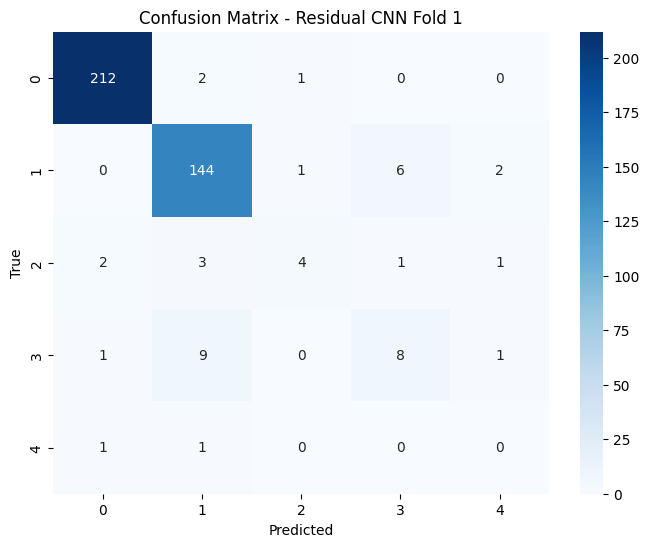

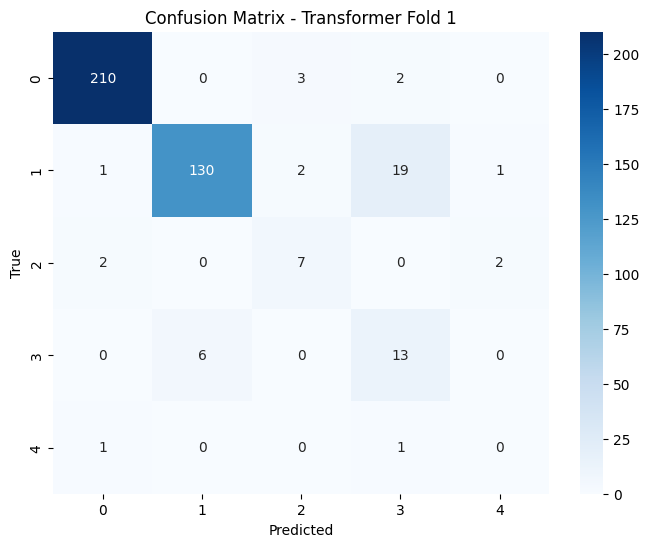

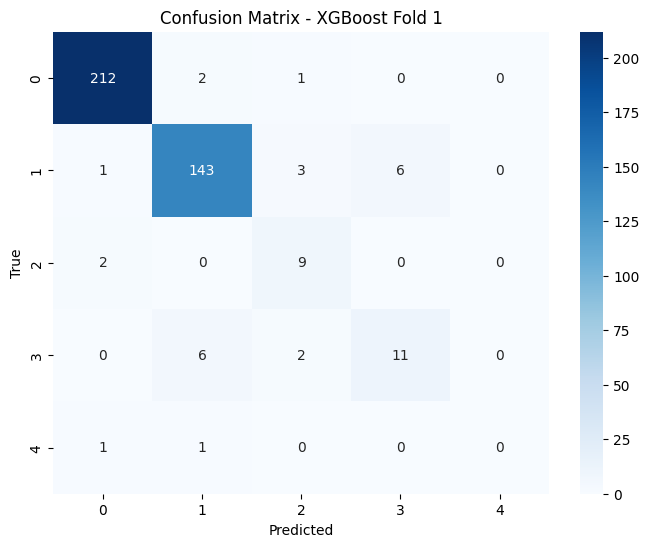

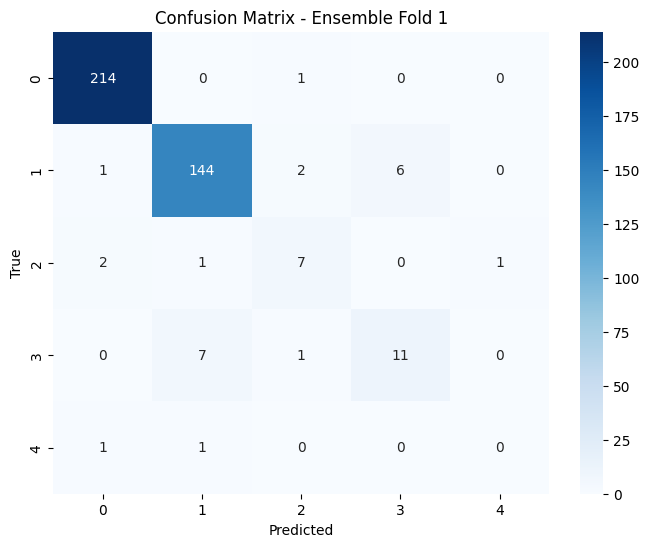

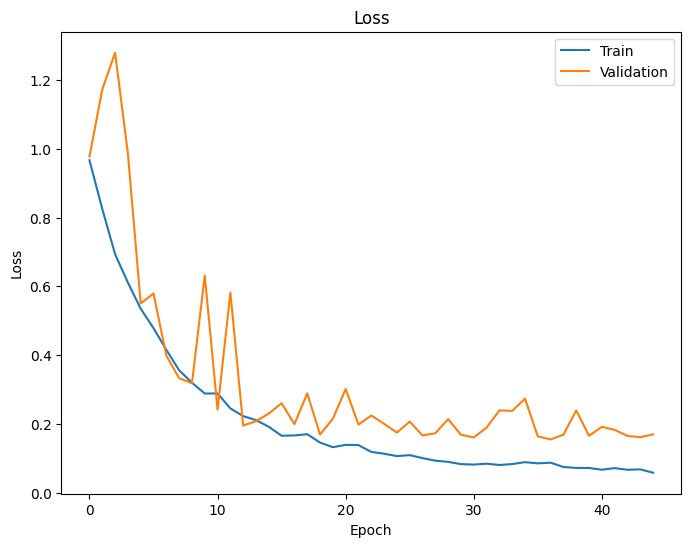

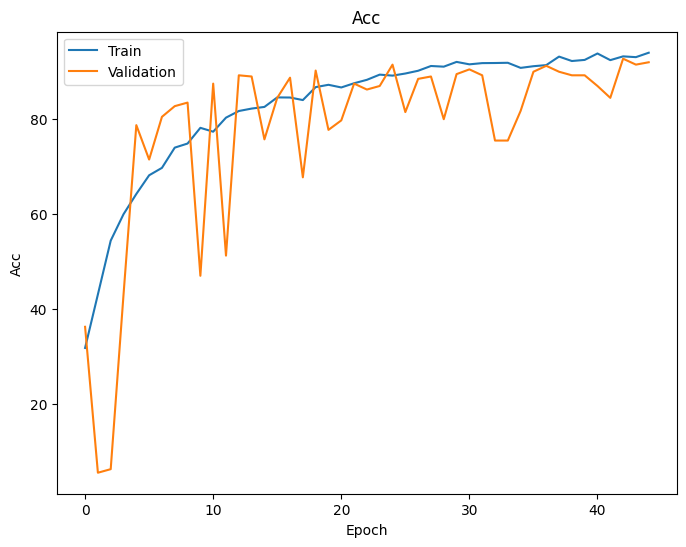

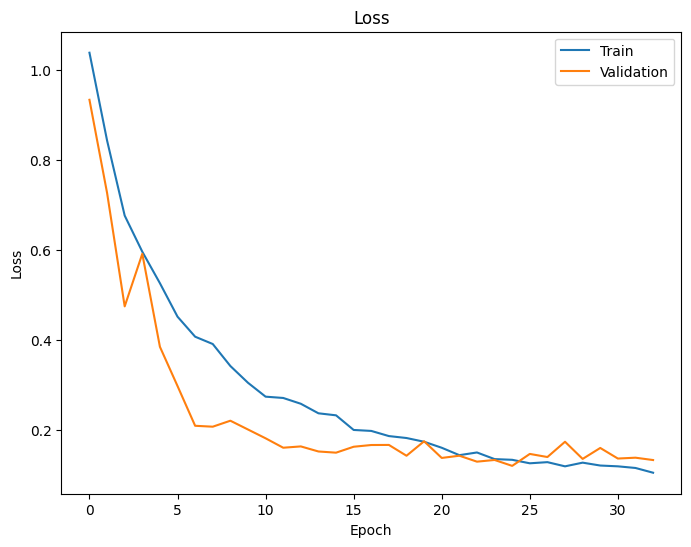

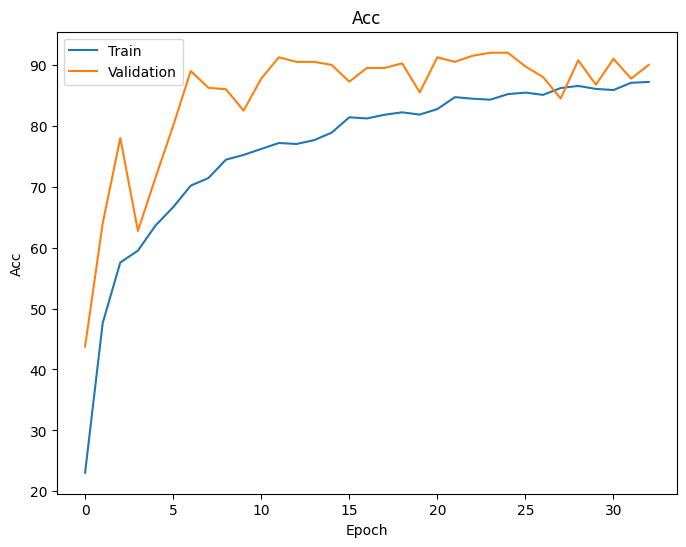


========== Fold 2 ==========

Training Residual CNN...
Epoch 1/50: Train Loss: 0.9337, Val Loss: 0.9786, Train Acc: 36.81%, Val Acc: 52.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50: Train Loss: 0.7843, Val Loss: 1.1075, Train Acc: 50.82%, Val Acc: 6.00%
Epoch 3/50: Train Loss: 0.6760, Val Loss: 1.3884, Train Acc: 57.62%, Val Acc: 5.50%
Epoch 4/50: Train Loss: 0.5879, Val Loss: 1.2264, Train Acc: 61.89%, Val Acc: 10.50%
Epoch 5/50: Train Loss: 0.5200, Val Loss: 0.7542, Train Acc: 64.85%, Val Acc: 62.50%
Epoch 6/50: Train Loss: 0.4423, Val Loss: 0.7338, Train Acc: 69.00%, Val Acc: 53.00%
Epoch 7/50: Train Loss: 0.3998, Val Loss: 0.2833, Train Acc: 72.05%, Val Acc: 87.50%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/50: Train Loss: 0.3503, Val Loss: 0.3529, Train Acc: 73.73%, Val Acc: 80.00%
Epoch 9/50: Train Loss: 0.2895, Val Loss: 0.2429, Train Acc: 78.88%, Val Acc: 85.50%
Epoch 10/50: Train Loss: 0.2669, Val Loss: 0.2440, Train Acc: 78.93%, Val Acc: 78.50%
Epoch 11/50: Train Loss: 0.2483, Val Loss: 0.1735, Train Acc: 79.98%, Val Acc: 89.00%
Epoch 12/50: Train Loss: 0.2268, Val Loss: 0.1988, Train Acc: 80.61%, Val Acc: 85.00%
Epoch 13/50: Train Loss: 0.2153, Val Loss: 0.1571, Train Acc: 81.63%, Val Acc: 88.75%
Epoch 14/50: Train Loss: 0.1859, Val Loss: 0.2243, Train Acc: 83.92%, Val Acc: 87.50%
Epoch 15/50: Train Loss: 0.1845, Val Loss: 0.1504, Train Acc: 83.12%, Val Acc: 91.50%
Epoch 16/50: Train Loss: 0.1639, Val Loss: 0.1509, Train Acc: 84.64%, Val Acc: 90.50%
Epoch 17/50: Train Loss: 0.1548, Val Loss: 0.1683, Train Acc: 85.48%, Val Acc: 90.25%
Epoch 18/50: Train Loss: 0.1460, Val Loss: 0.1860, Train Acc: 84.62%, Val Acc: 81.00%
Epoch 19/50: Train Loss: 0.1394, Val Loss: 0.1816, Train

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Individual Model Accuracies:
Residual CNN Fold 2 Accuracy: 0.8025
Transformer Fold 2 Accuracy: 0.8650
XGBoost Fold 2 Accuracy: 0.9275
Ensemble Fold 2 Accuracy: 0.9100


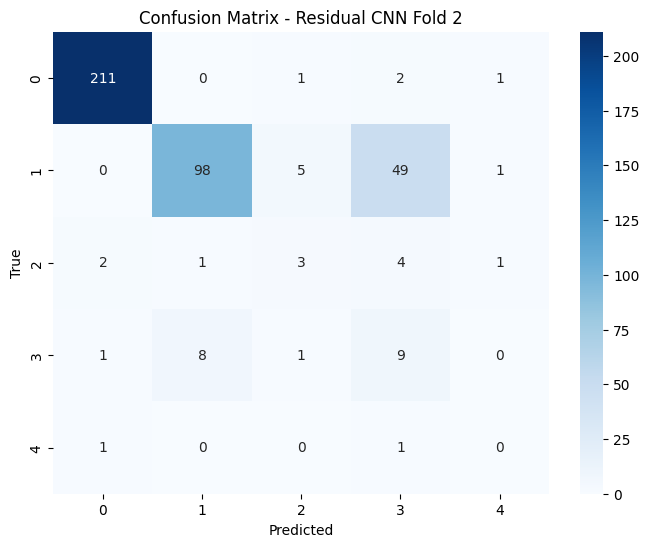

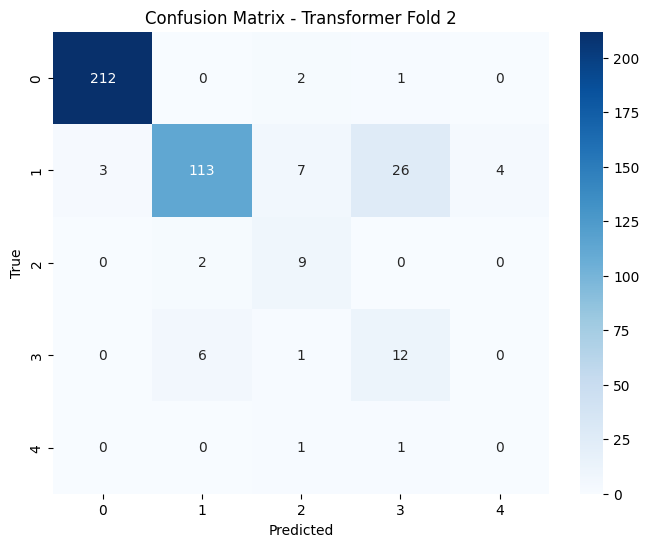

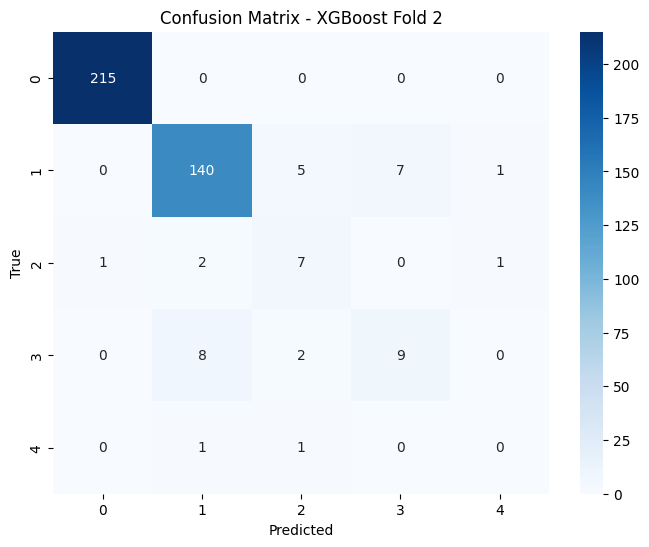

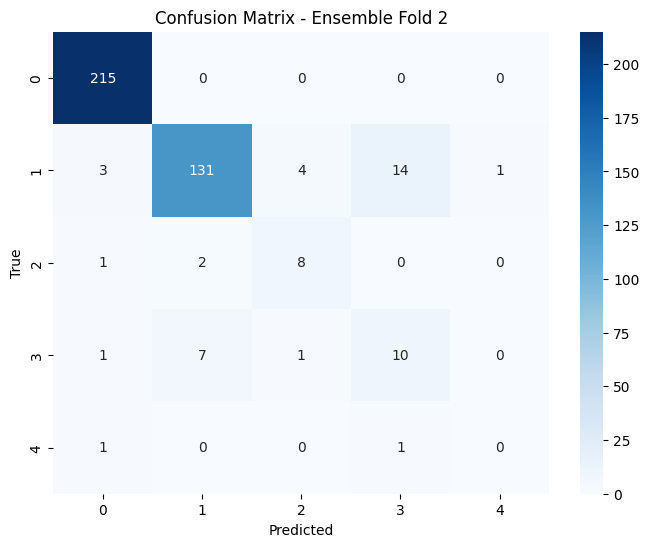

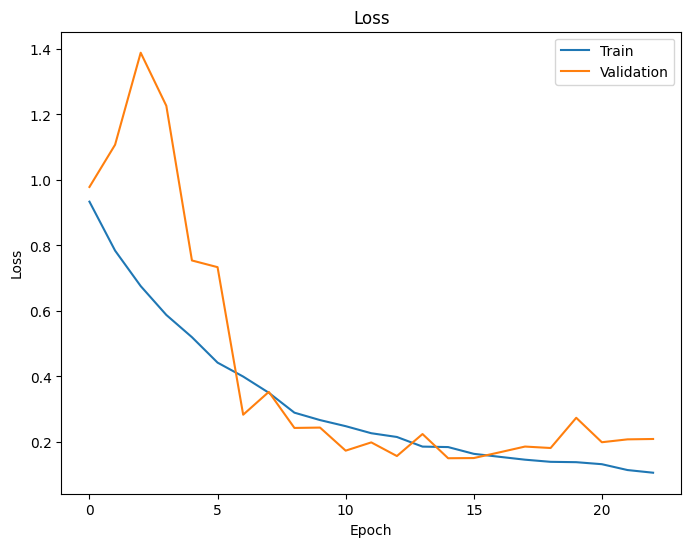

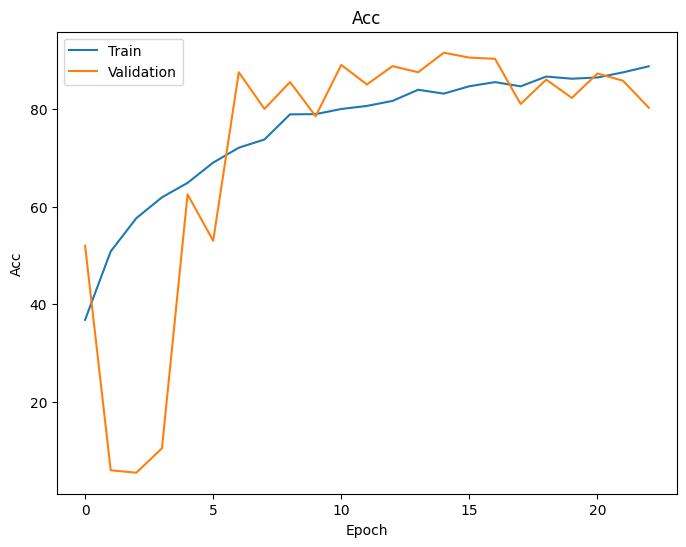

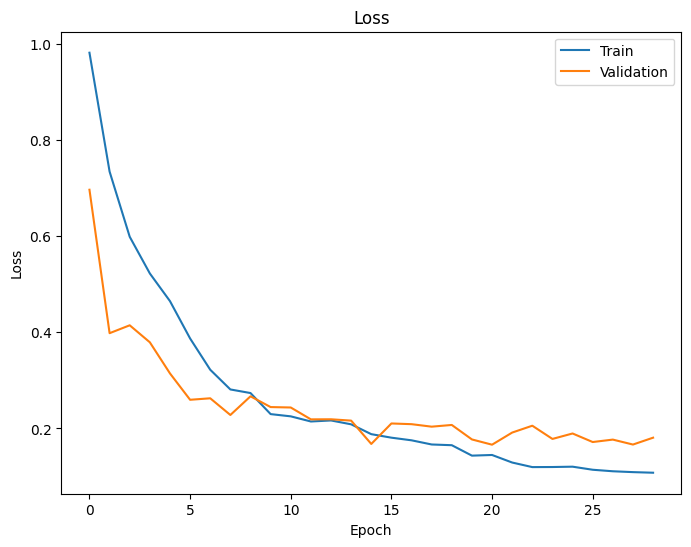

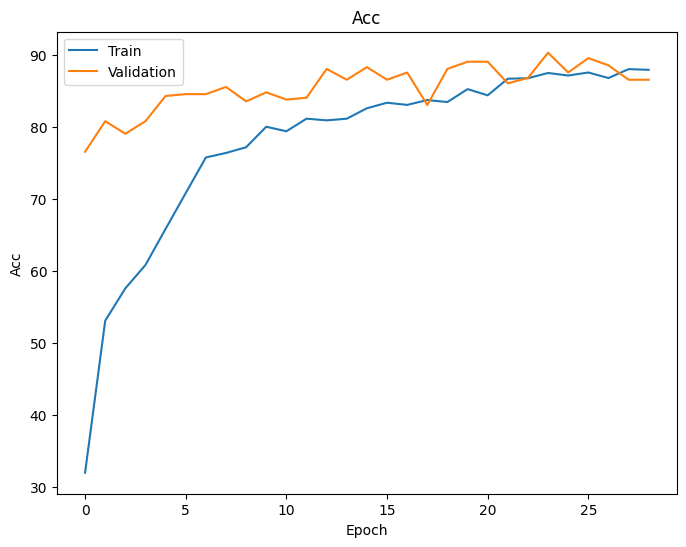


========== Fold 3 ==========

Training Residual CNN...
Epoch 1/50: Train Loss: 0.9825, Val Loss: 0.9970, Train Acc: 30.49%, Val Acc: 43.50%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50: Train Loss: 0.8295, Val Loss: 1.0181, Train Acc: 47.83%, Val Acc: 8.00%
Epoch 3/50: Train Loss: 0.7013, Val Loss: 1.1767, Train Acc: 56.25%, Val Acc: 3.50%
Epoch 4/50: Train Loss: 0.6054, Val Loss: 1.2201, Train Acc: 61.00%, Val Acc: 13.75%
Epoch 5/50: Train Loss: 0.5325, Val Loss: 0.6656, Train Acc: 65.17%, Val Acc: 66.75%
Epoch 6/50: Train Loss: 0.4679, Val Loss: 0.3757, Train Acc: 68.95%, Val Acc: 81.00%
Epoch 7/50: Train Loss: 0.3995, Val Loss: 0.2687, Train Acc: 71.03%, Val Acc: 84.75%
Epoch 8/50: Train Loss: 0.3715, Val Loss: 0.4044, Train Acc: 73.19%, Val Acc: 75.50%
Epoch 9/50: Train Loss: 0.3192, Val Loss: 0.2429, Train Acc: 76.06%, Val Acc: 86.00%
Epoch 10/50: Train Loss: 0.2910, Val Loss: 0.2940, Train Acc: 77.02%, Val Acc: 81.25%
Epoch 11/50: Train Loss: 0.2689, Val Loss: 0.2303, Train Acc: 77.86%, Val Acc: 84.50%
Epoch 12/50: Train Loss: 0.2505, Val Loss: 0.1780, Train Acc: 78.67%, Val Acc: 89.25%
Epoch 13/50: Train Loss: 0.2207, Val Loss: 0.2603, Train Acc: 80

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:50:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Individual Model Accuracies:
Residual CNN Fold 3 Accuracy: 0.9175
Transformer Fold 3 Accuracy: 0.8975
XGBoost Fold 3 Accuracy: 0.9375
Ensemble Fold 3 Accuracy: 0.9350


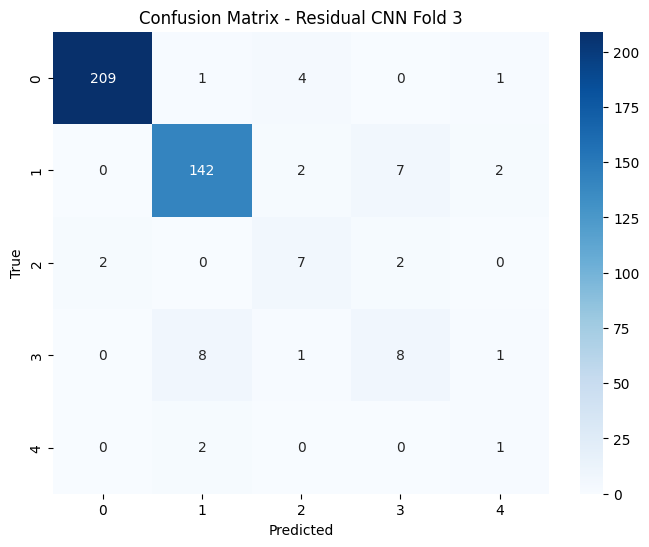

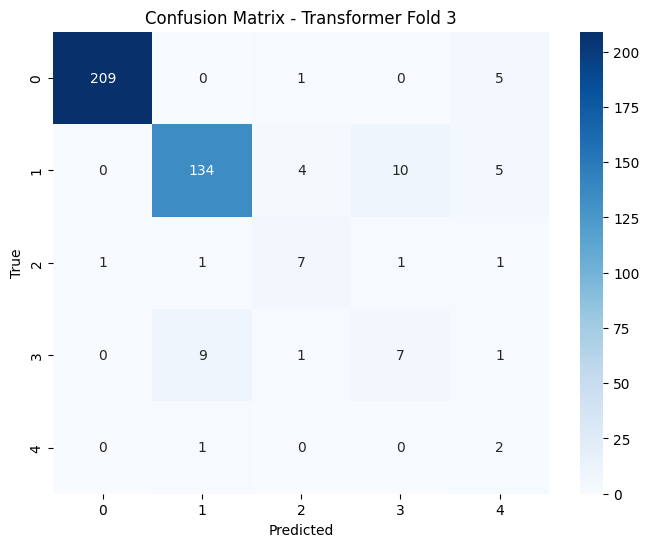

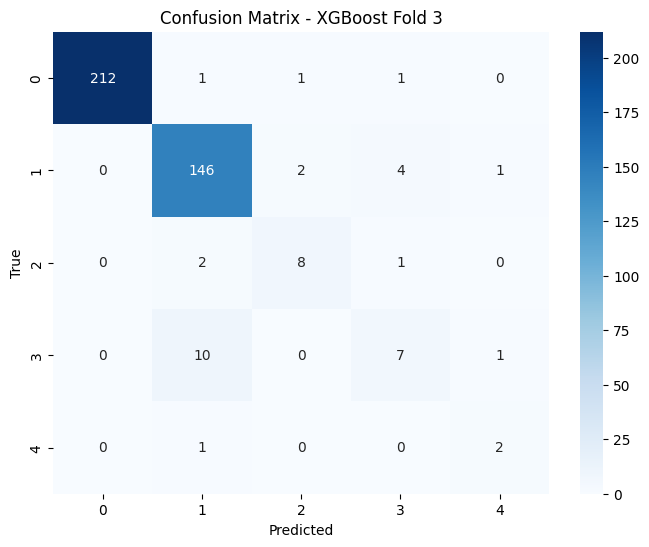

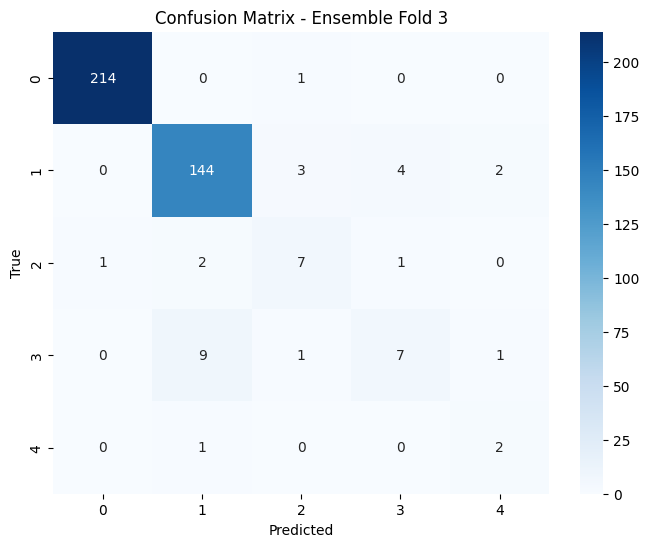

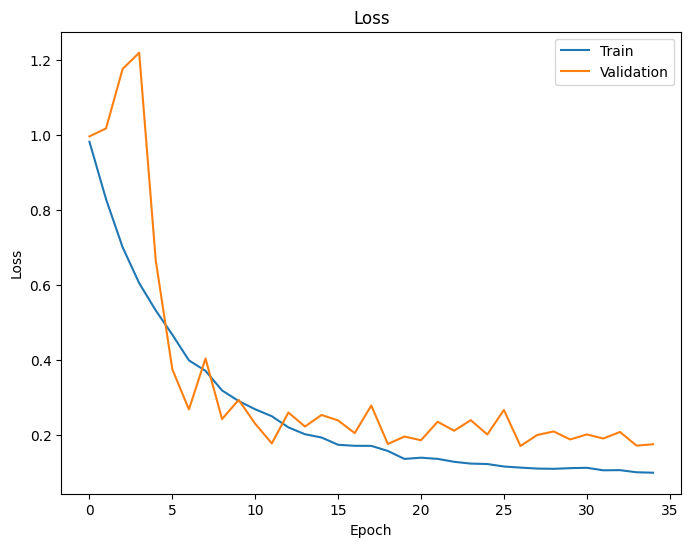

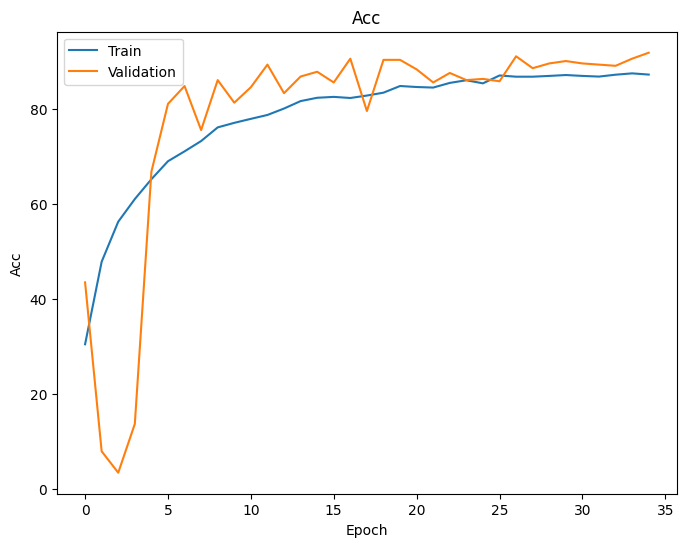

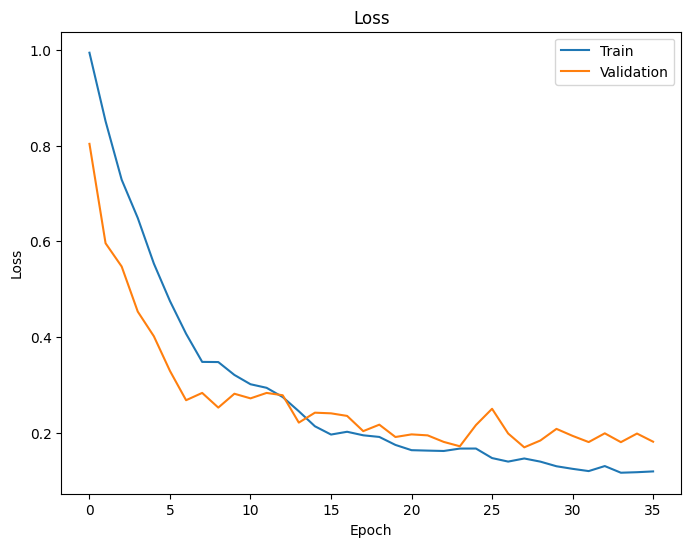

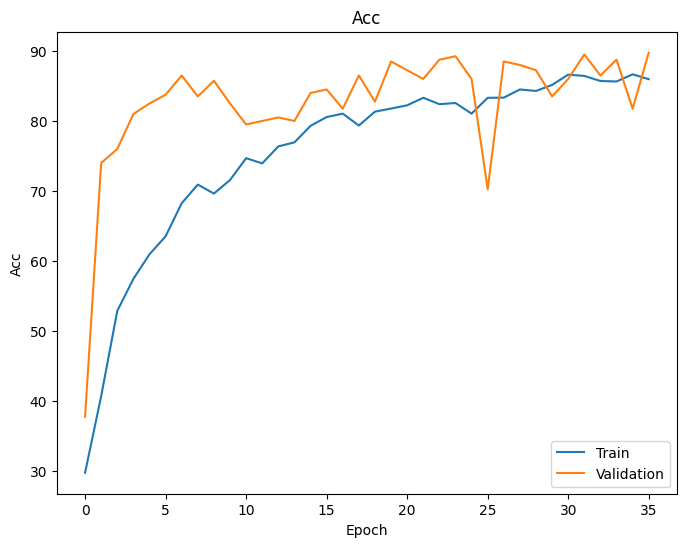


========== Fold 4 ==========

Training Residual CNN...
Epoch 1/50: Train Loss: 0.9447, Val Loss: 1.0415, Train Acc: 31.90%, Val Acc: 3.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50: Train Loss: 0.7944, Val Loss: 1.0326, Train Acc: 47.61%, Val Acc: 5.50%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50: Train Loss: 0.6871, Val Loss: 1.1706, Train Acc: 54.71%, Val Acc: 8.75%
Epoch 4/50: Train Loss: 0.5981, Val Loss: 1.1859, Train Acc: 59.86%, Val Acc: 13.25%
Epoch 5/50: Train Loss: 0.5029, Val Loss: 1.1972, Train Acc: 65.33%, Val Acc: 25.00%
Epoch 6/50: Train Loss: 0.4237, Val Loss: 1.0142, Train Acc: 69.38%, Val Acc: 27.25%
Epoch 7/50: Train Loss: 0.3654, Val Loss: 0.8789, Train Acc: 72.29%, Val Acc: 47.25%
Epoch 8/50: Train Loss: 0.3262, Val Loss: 0.6196, Train Acc: 74.76%, Val Acc: 64.75%
Epoch 9/50: Train Loss: 0.2968, Val Loss: 0.3588, Train Acc: 74.74%, Val Acc: 75.75%
Epoch 10/50: Train Loss: 0.2599, Val Loss: 0.2537, Train Acc: 77.60%, Val Acc: 85.00%
Epoch 11/50: Train Loss: 0.2419, Val Loss: 0.3442, Train Acc: 78.32%, Val Acc: 80.00%
Epoch 12/50: Train Loss: 0.2241, Val Loss: 0.2655, Train Acc: 78.65%, Val Acc: 85.50%
Epoch 13/50: Train Loss: 0.2197, Val Loss: 0.2748, Train Acc: 79.86%, Val Acc: 81.75%
Epoch 14/50: Train Loss: 0.2057, Val Loss: 0.1492, Train Acc: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:52:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Individual Model Accuracies:
Residual CNN Fold 4 Accuracy: 0.8950
Transformer Fold 4 Accuracy: 0.9250
XGBoost Fold 4 Accuracy: 0.9475
Ensemble Fold 4 Accuracy: 0.9500


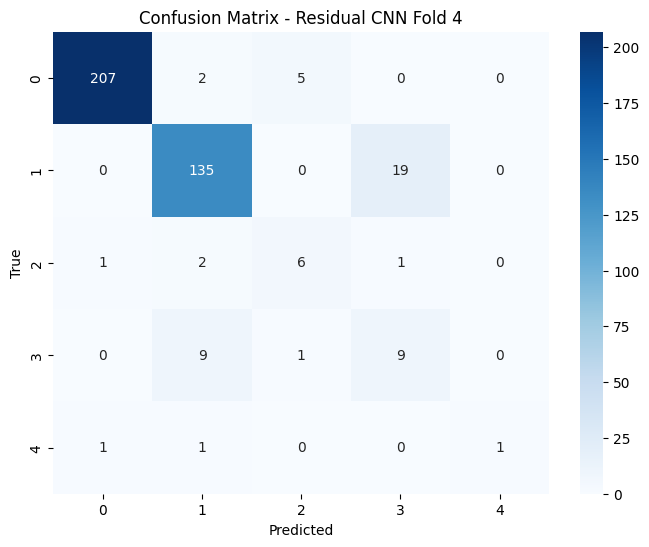

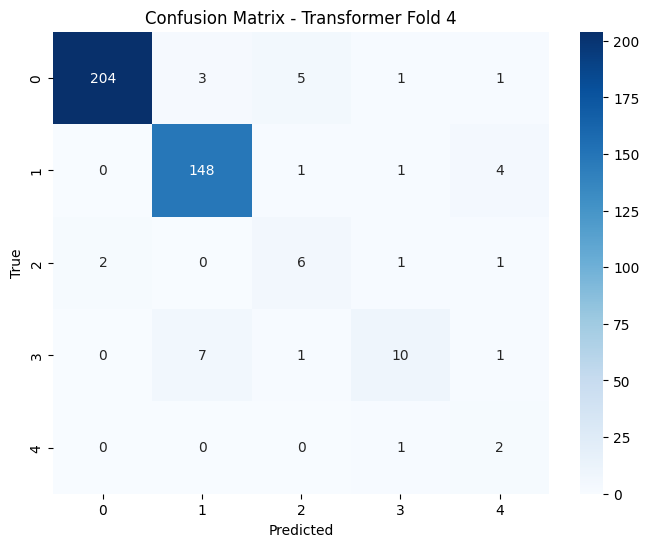

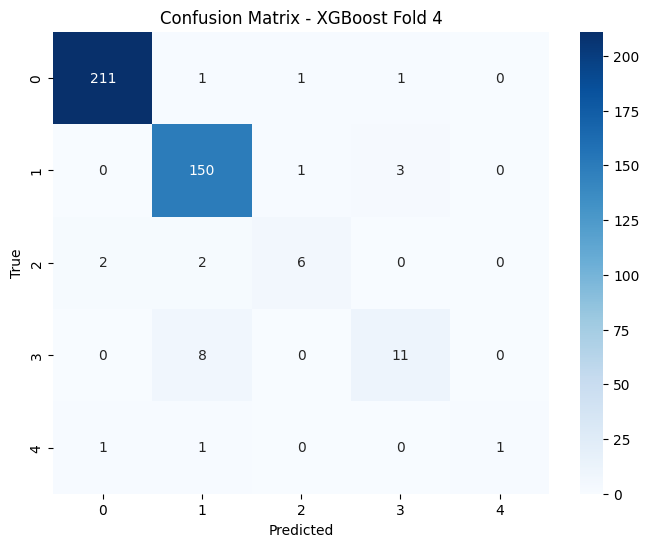

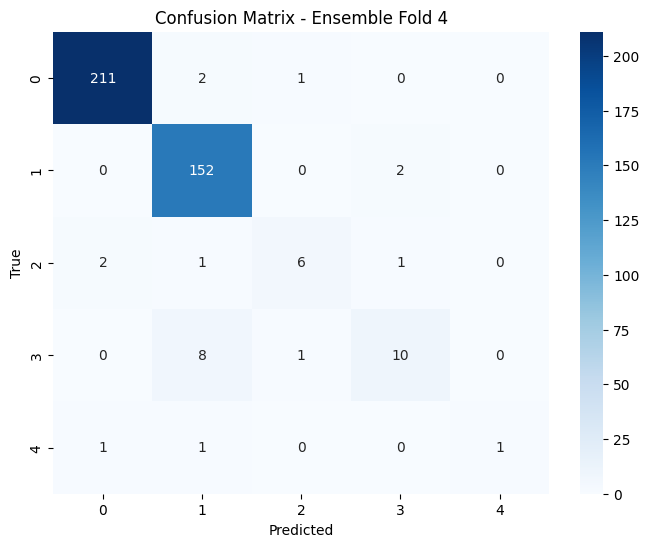

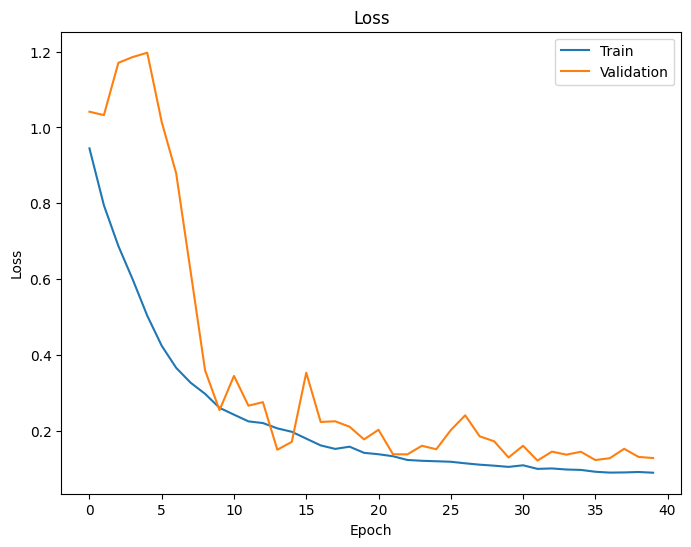

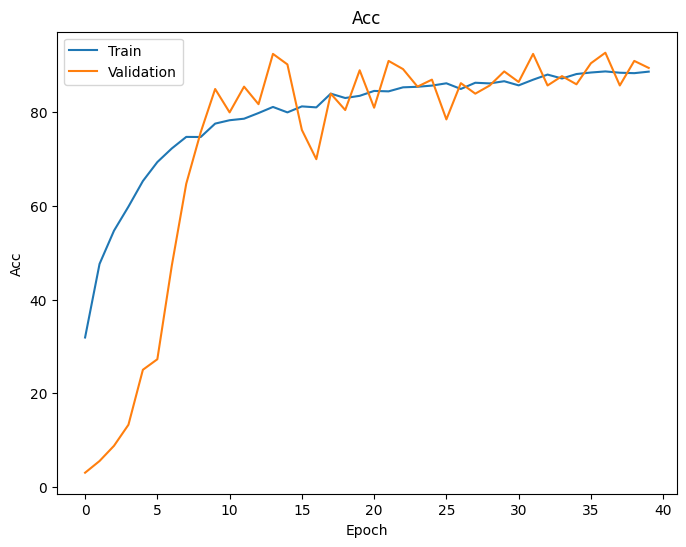

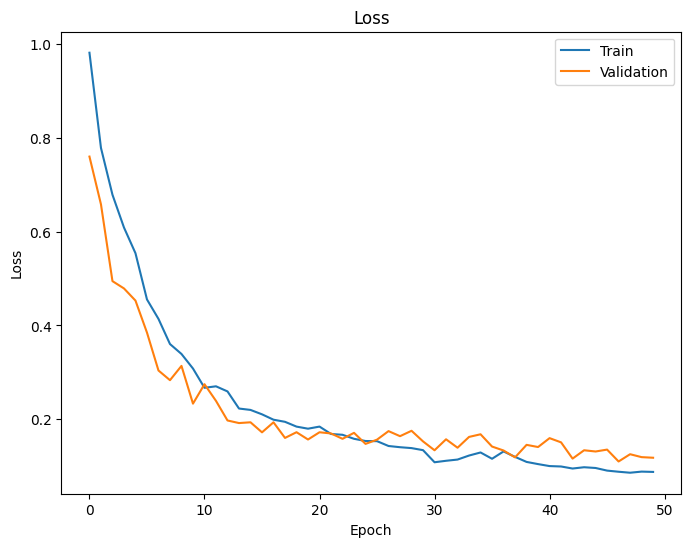

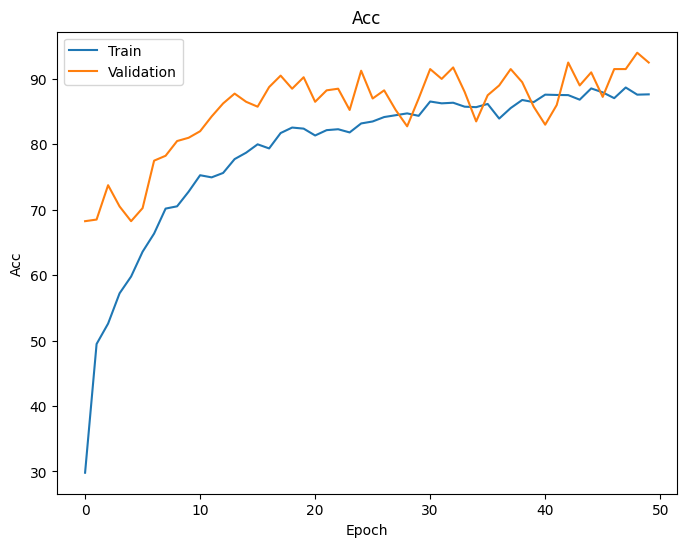


========== Fold 5 ==========

Training Residual CNN...
Epoch 1/50: Train Loss: 0.9629, Val Loss: 1.0558, Train Acc: 31.97%, Val Acc: 4.75%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50: Train Loss: 0.8096, Val Loss: 1.3573, Train Acc: 47.87%, Val Acc: 4.00%
Epoch 3/50: Train Loss: 0.6978, Val Loss: 1.9725, Train Acc: 56.07%, Val Acc: 2.50%
Epoch 4/50: Train Loss: 0.6197, Val Loss: 1.7489, Train Acc: 60.63%, Val Acc: 2.75%
Epoch 5/50: Train Loss: 0.5438, Val Loss: 0.5987, Train Acc: 64.38%, Val Acc: 66.25%
Epoch 6/50: Train Loss: 0.4632, Val Loss: 0.6082, Train Acc: 68.94%, Val Acc: 60.25%
Epoch 7/50: Train Loss: 0.4229, Val Loss: 0.4418, Train Acc: 70.41%, Val Acc: 69.00%
Epoch 8/50: Train Loss: 0.3769, Val Loss: 0.4103, Train Acc: 73.02%, Val Acc: 71.75%
Epoch 9/50: Train Loss: 0.3447, Val Loss: 0.2893, Train Acc: 74.95%, Val Acc: 81.25%
Epoch 10/50: Train Loss: 0.3024, Val Loss: 0.3117, Train Acc: 76.34%, Val Acc: 80.00%
Epoch 11/50: Train Loss: 0.2776, Val Loss: 0.2398, Train Acc: 78.11%, Val Acc: 80.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/50: Train Loss: 0.2423, Val Loss: 0.1912, Train Acc: 79.19%, Val Acc: 88.75%
Epoch 13/50: Train Loss: 0.2349, Val Loss: 0.1939, Train Acc: 80.40%, Val Acc: 91.75%
Epoch 14/50: Train Loss: 0.1976, Val Loss: 0.4032, Train Acc: 82.28%, Val Acc: 65.75%
Epoch 15/50: Train Loss: 0.1854, Val Loss: 0.3880, Train Acc: 82.33%, Val Acc: 73.25%
Epoch 16/50: Train Loss: 0.1717, Val Loss: 0.3984, Train Acc: 84.49%, Val Acc: 65.00%
Epoch 17/50: Train Loss: 0.1798, Val Loss: 0.8324, Train Acc: 83.75%, Val Acc: 46.75%
Epoch 18/50: Train Loss: 0.1679, Val Loss: 0.4853, Train Acc: 84.49%, Val Acc: 77.75%
Epoch 19/50: Train Loss: 0.1636, Val Loss: 0.1741, Train Acc: 84.56%, Val Acc: 86.50%
Epoch 20/50: Train Loss: 0.1409, Val Loss: 0.1904, Train Acc: 85.33%, Val Acc: 85.50%
Epoch 21/50: Train Loss: 0.1271, Val Loss: 0.1834, Train Acc: 86.54%, Val Acc: 89.00%
Epoch 22/50: Train Loss: 0.1306, Val Loss: 0.1795, Train Acc: 86.73%, Val Acc: 89.50%
Epoch 23/50: Train Loss: 0.1190, Val Loss: 0.2568, Tra

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Individual Model Accuracies:
Residual CNN Fold 5 Accuracy: 0.8300
Transformer Fold 5 Accuracy: 0.8725
XGBoost Fold 5 Accuracy: 0.9425
Ensemble Fold 5 Accuracy: 0.9275


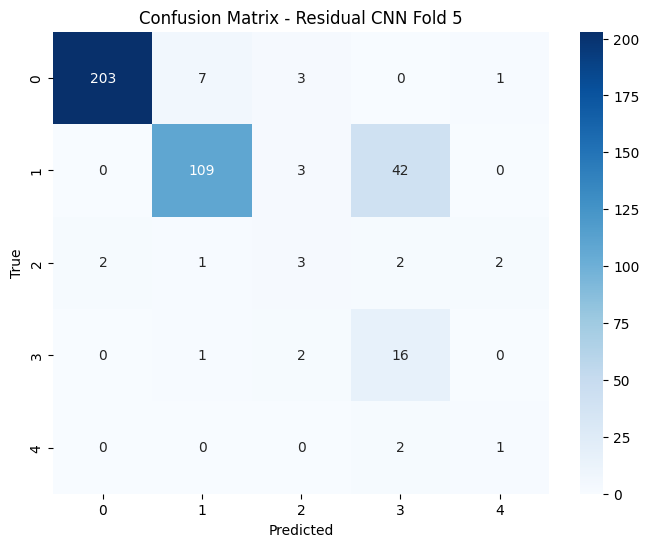

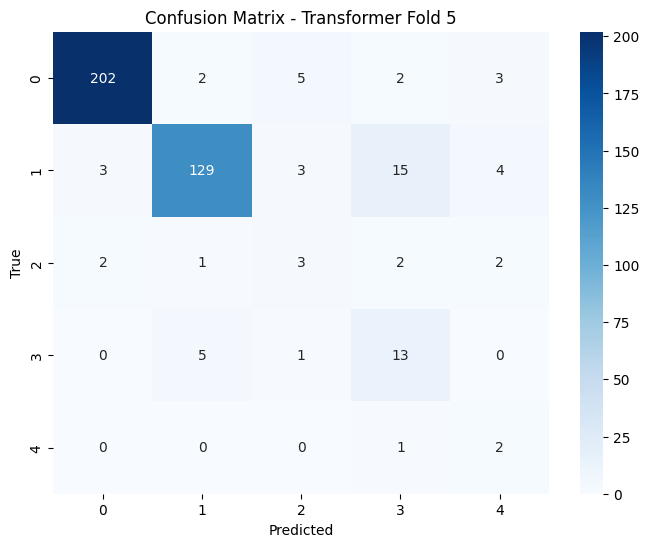

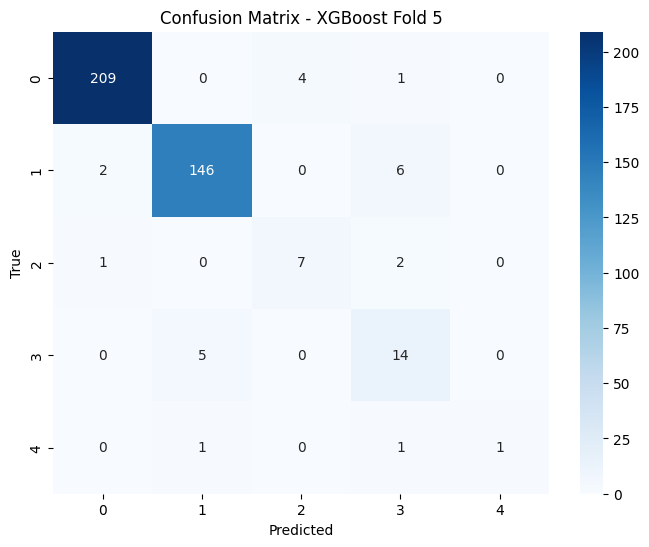

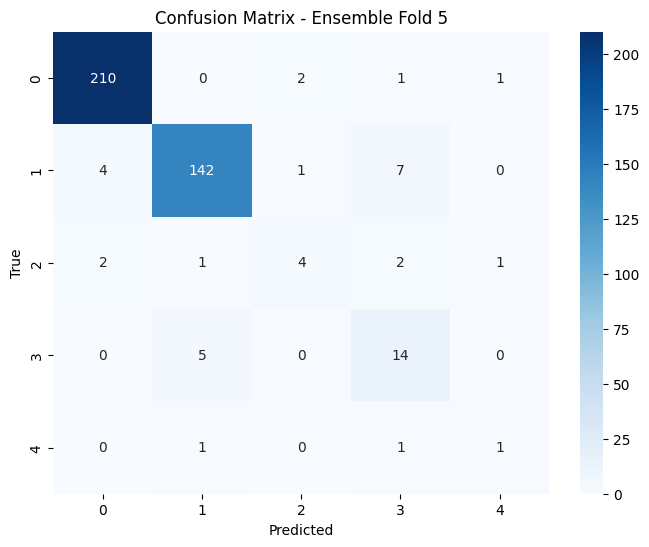

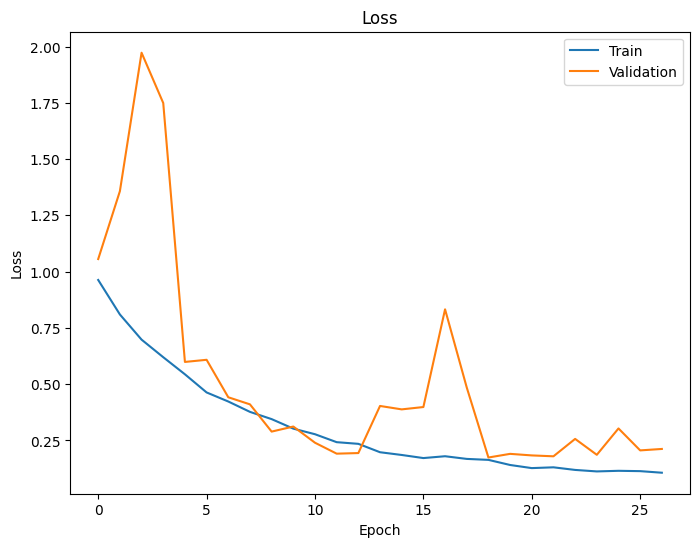

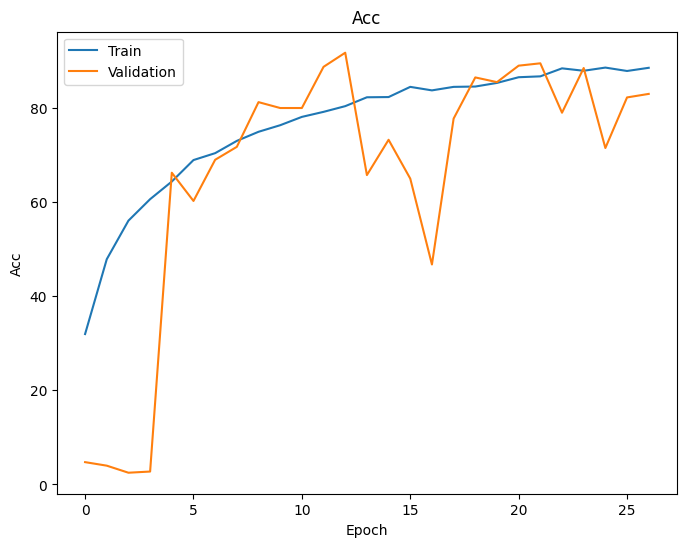

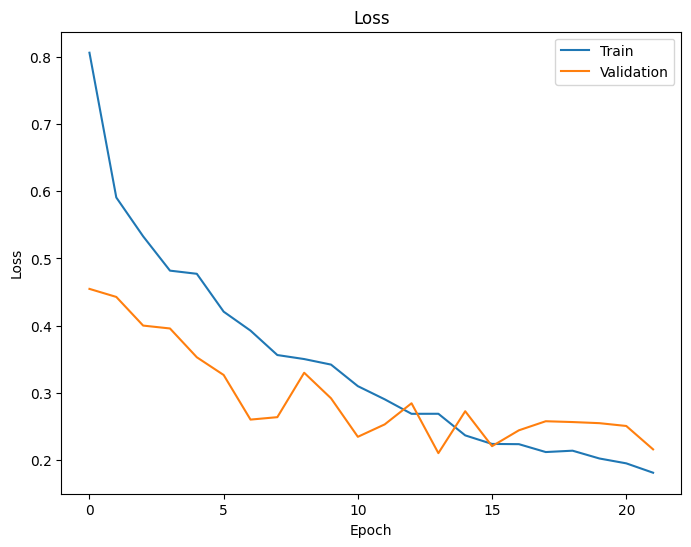

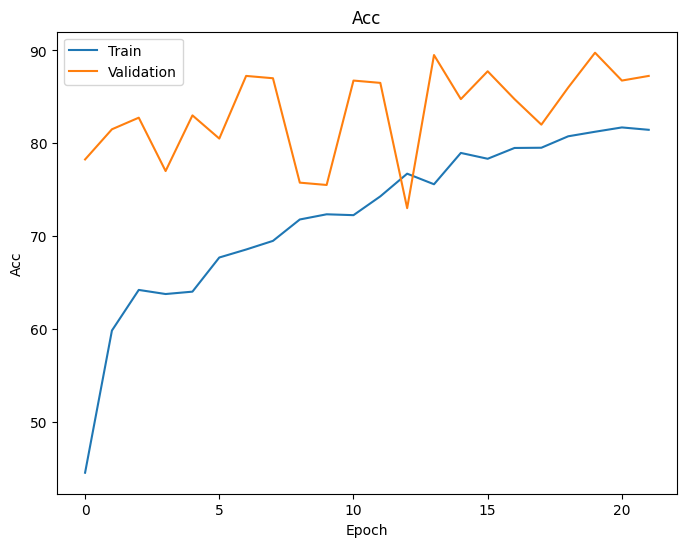


==== Final Results Across All Folds ====

Average Individual Model Accuracies:
CNN: 0.8730
Transformer: 0.8920
XGBoost: 0.9385
Ensemble: 0.9325

==== Experiment Completed ====


In [ ]:
if __name__ == '__main__':
    main()